# Triple Pendulum CHAOS!

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2017/03/08/triple-pendulum-chaos/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is MIT licensed.*

<!-- PELICAN_BEGIN_SUMMARY -->

Earlier this week a tweet made the rounds which features a video that nicely demonstrates chaotic dynamical systems in action:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">A visualization of chaos: 41 triple pendulums with very slightly different initial conditions <a href="https://t.co/CTiABFVWHW">pic.twitter.com/CTiABFVWHW</a></p>&mdash; Fermat&#39;s Library (@fermatslibrary) <a href="https://twitter.com/fermatslibrary/status/838392423063687168">March 5, 2017</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

*Edit: a reader pointed out that the original creator of this animation [posted it on reddit](https://www.reddit.com/r/mathpics/comments/4nd5h1/41_triple_pendulums_with_very_slightly_different/) in 2016.*

Naturally, I immediately wondered whether I could reproduce this simlulation in Python.
This post is the result.

<!-- PELICAN_END_SUMMARY -->

This should have been pretty easy. After all, a while back I wrote a [Matplotlib Animation Tutorial](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/) containing a double pendulum example, simulated in Python using SciPy's [``odeint`` solver](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.integrate.odeint.html) and animated using matplotlib's [animation module](http://matplotlib.org/api/animation_api.html).
All we need to do is to extend that to a three-segment pendulum, and we're good to go, right?

Unfortunately, things are not so simple.
While the double pendulum equations of motion can be solved [relatively straightforwardly](http://scienceworld.wolfram.com/physics/DoublePendulum.html), the equations for a triple pendulum are much more involved.
For example, the appendix of [this document](https://www.nickeyre.com/images/triplependulum.pdf) lists the three coupled second-order differential equations that govern the motion of the a triple pendulum;
here's a screenshot of just the first of those three:

![Equation Screenshot](http://jakevdp.github.io/images/eqn-screenshot.png)

Yikes.

Fortunately, there are easier approaches than brute-force algebra, that rely on higher abstractions: one such approach is known as [Kane's Method](http://docs.sympy.org/dev/modules/physics/mechanics/kane.html).
This method still involves a significant amount of book-keeping for any but the most trivial problems, but the [Sympy package](http://sympy.org) has a nice implementation that handles the details for you.
This is the approach I took to simulate the triple pendulum, borrowing heavily from  [Gede et al. 2013](https://www.researchgate.net/publication/267490975_Constrained_Multibody_Dynamics_With_Python_From_Symbolic_Equation_Generation_to_Publication) who present a nice example of Sympy's API for applying Kane's Method.

## The Code

The following function defines and solves the equations of motion for a system of *n* pendulums, with arbitrary masses and lengths.
It's a bit long, but hopefully commented well enough that you can follow along.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint


def integrate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1):
    """Integrate a multi-pendulum with `n` sections"""
    #-------------------------------------------------
    # Step 1: construct the pendulum model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(particles, forces)
    
    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                    np.broadcast_to(initial_velocities, n)]))
        
    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))

## Extracting Positions

The function above returns generalized coordinates, which in this case are the angular position and velocity of each pendulum segment, relative to vertical.
To visualize the pendulum, we need a quick utility to extract *x* and *y* coordinates from these angular coordinates:

In [2]:
def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

Finally, we can call this function to simulate a pendulum at a set of times *t*.
Here are the paths of a double pendulum over time:

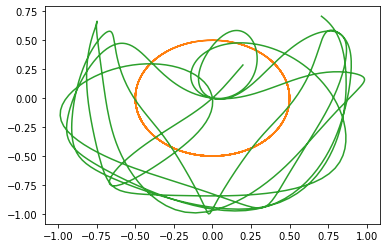

In [3]:
t = np.linspace(0, 10, 1000)
p = integrate_pendulum(n=2, times=t)
x, y = get_xy_coords(p)
plt.plot(x, y);

And here are the positions of a triple pendulum over time:

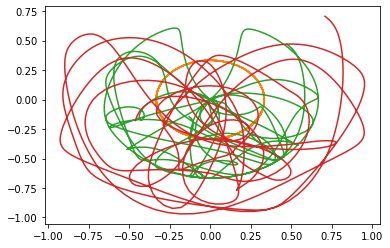

In [4]:
p = integrate_pendulum(n=3, times=t)
x, y = get_xy_coords(p)
plt.plot(x, y);

## Pendulum Animations

The static plots above provide a bit of insight into the situation, but it's much more intuitive to see the results as an animation.
Drawing from the double pendulum code in my [Animation Tutorial](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/), here is a function to animate the pendulum's motion over time:

In [5]:
from matplotlib import animation


def animate_pendulum(n):
    t = np.linspace(0, 10, 200)
    p = integrate_pendulum(n, t)
    x, y = get_xy_coords(p)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x[i], y[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(t),
                                   interval=1000 * t.max() / len(t),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

In [6]:
anim = animate_pendulum(3)

In the notebook, you can embed the resulting animation using the following snippet:

```python
from IPython.display import HTML
HTML(anim.to_html5_video())
```

Embedding videos directly like this can lead to very large file sizes for notebooks (and blog posts!), so instead I've saved the animation and will load it with an HTML5 video tag.
This is less portable (because the video file is separate from the notebook) but avoids embedding the entire content of the video into the single notebook file.

In [7]:
from IPython.display import HTML
anim.save('triple-pendulum.mp4', extra_args=['-vcodec', 'libx264'])
#HTML('<video controls loop src="http://jakevdp.github.io/videos/triple-pendulum.mp4" />')

The nice part about the Kane method implemented above is that it readily generalizes to larger compound pendulums; for example, here is an animation of a 5-part "quintuple pendulum".
It takes a bit longer to run, but can be computed with the same code:

In [8]:
anim = animate_pendulum(5)
HTML(anim.to_html5_video())  # uncomment to embed

In [9]:
# anim.save('quintuple-pendulum.mp4', extra_args=['-vcodec', 'libx264'])
HTML('<video controls loop src="http://jakevdp.github.io/videos/quintuple-pendulum.mp4" />')

## And a Butterfly Flaps its Wings...

And now back to the motivation of this post: illustrating the chaotic results of small perturbations in initial conditions.
The following code animates any specified number of nearly identical pendulums, each with a starting location perturbed slightly (here by about one part in a million):

In [10]:
from matplotlib import collections


def animate_pendulum_multiple(n, n_pendulums=41, perturbation=1E-6, track_length=15):
    oversample = 3
    track_length *= oversample
    
    t = np.linspace(0, 10, oversample * 200)
    p = [integrate_pendulum(n, t, initial_positions=135 + i * perturbation / n_pendulums)
         for i in range(n_pendulums)]
    positions = np.array([get_xy_coords(pi) for pi in p])
    positions = positions.transpose(0, 2, 3, 1)
    # positions is a 4D array: (npendulums, len(t), n+1, xy)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    track_segments = np.zeros((n_pendulums, 0, 2))
    tracks = collections.LineCollection(track_segments, cmap='rainbow')
    tracks.set_array(np.linspace(0, 1, n_pendulums))
    ax.add_collection(tracks)
    
    points, = plt.plot([], [], 'ok')
    
    pendulum_segments = np.zeros((n_pendulums, 0, 2))
    pendulums = collections.LineCollection(pendulum_segments, colors='black')
    ax.add_collection(pendulums)

    def init():
        pendulums.set_segments(np.zeros((n_pendulums, 0, 2)))
        tracks.set_segments(np.zeros((n_pendulums, 0, 2)))
        points.set_data([], [])
        return pendulums, tracks, points

    def animate(i):
        i = i * oversample
        pendulums.set_segments(positions[:, i])
        sl = slice(max(0, i - track_length), i)
        tracks.set_segments(positions[:, sl, -1])
        x, y = positions[:, i].reshape(-1, 2).T
        points.set_data(x, y)
        return pendulums, tracks, points

    interval = 1000 * oversample * t.max() / len(t)
    anim = animation.FuncAnimation(fig, animate, frames=len(t) // oversample,
                                   interval=interval,
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim
    
anim = animate_pendulum_multiple(3)
HTML(anim.to_html5_video())  # uncomment to embed

In [11]:
anim.save('triple-pendulum-chaos.mp4', extra_args=['-vcodec', 'libx264'])
HTML('<video controls loop src="http://jakevdp.github.io/videos/triple-pendulum-chaos.mp4" />')

Quite similar to the video that made the rounds on twitter, but the benefit here is that the result can be reproduced from scratch with the above code.

Thanks for reading!

*This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/TriplePendulum.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/TriplePendulum.ipynb).*